In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("user_insights_dataset.csv")

In [4]:
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              2516 non-null   object 
 1   transaction_date     2516 non-null   object 
 2   revenue              2516 non-null   float64
 3   platform             2516 non-null   object 
 4   acquisition_channel  2516 non-null   object 
dtypes: float64(1), object(4)
memory usage: 98.4+ KB
None


In [5]:
print(data.isnull().sum())

user_id                0
transaction_date       0
revenue                0
platform               0
acquisition_channel    0
dtype: int64


In [6]:
# Converting transaction_date to datetime
data['transaction_date'] = pd.to_datetime(data['transaction_date'])

C:\Users\cheta\AppData\Local\Temp\ipykernel_17484\3869190571.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['transaction_date'] = pd.to_datetime(data['transaction_date'])


In [7]:
# Finding the first transaction date for each user
data['first_transaction_date'] = data.groupby('user_id')['transaction_date'].transform('min')

In [8]:
# Defining the cohort based on the first transaction month
data['cohort'] = data['first_transaction_date'].dt.to_period('M')

In [9]:
# Adding a column to identify repeat transactions
data['is_repeat'] = data['transaction_date'] > data['first_transaction_date']

In [10]:
# Counting users by cohort
cohort_counts = data.groupby('cohort')['user_id'].nunique()

In [11]:
# Counting repeat users by cohort
repeat_counts = data[data['is_repeat']].groupby('cohort')['user_id'].nunique()

In [12]:
# Calculating retention rate
retention_rate = (repeat_counts / cohort_counts) * 100
print(retention_rate)

cohort
2024-01    94.871795
2024-02    96.808511
2024-03    91.208791
2024-04    88.059701
2024-05    81.333333
2024-06    85.483871
2024-07    80.000000
2024-08    82.222222
2024-09    61.290323
2024-10    56.140351
2024-11    36.842105
2024-12    10.000000
Freq: M, Name: user_id, dtype: float64


In [16]:
import matplotlib.pyplot as plt

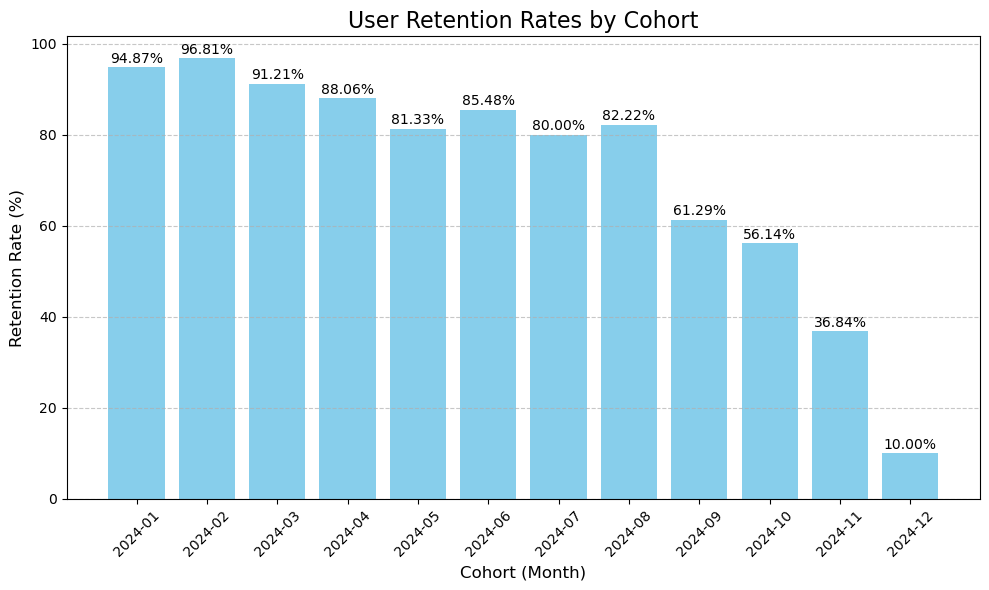

In [17]:
# Plot retention rates
plt.figure(figsize=(10, 6))
bars = plt.bar(retention_rate.index.astype(str), retention_rate, color='skyblue')

# Adding labels on each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.2f}%', ha='center', fontsize=10)

# Customized the chart
plt.title('User Retention Rates by Cohort', fontsize=16)
plt.xlabel('Cohort (Month)', fontsize=12)
plt.ylabel('Retention Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [20]:
# Group by acquisition_channel to calculate total revenue and unique user counts
channel_data = data.groupby('acquisition_channel').agg({
    'revenue': 'sum',                # Total revenue by channel
    'user_id': pd.Series.nunique     # Unique user count by channel
}).reset_index()

In [21]:
# Calculating ARPU (Average Revenue Per User)
channel_data['ARPU'] = channel_data['revenue'] / channel_data['user_id']

In [22]:
# Sorting channels by ARPU for clarity
channel_data_sorted = channel_data.sort_values('ARPU', ascending=False)
print(channel_data_sorted)

  acquisition_channel   revenue  user_id       ARPU
2          Google Ads  26911.38      348  77.331552
4            Referral  26307.95      358  73.485894
1        Facebook Ads  26982.82      368  73.322880
3      Organic Search  25780.98      368  70.057011
0      Email Campaign  25199.05      368  68.475679


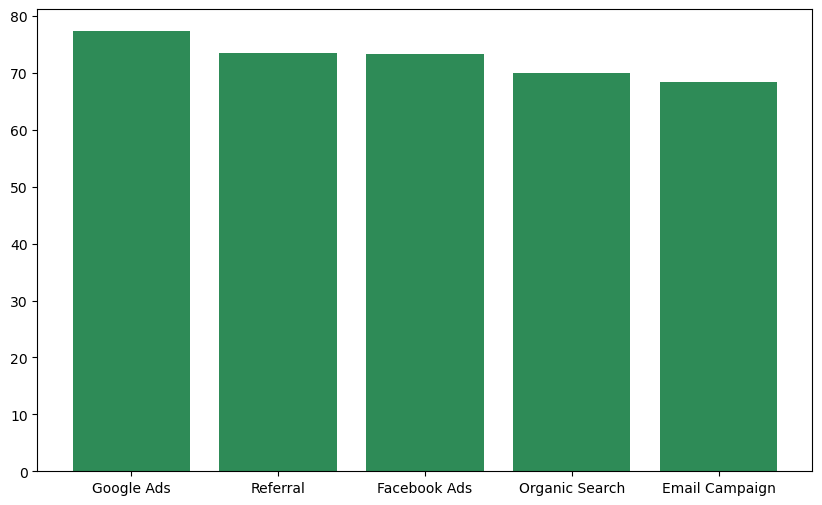

In [23]:
# Visualizing ARPU by acquisition channel
plt.figure(figsize=(10, 6))
bars = plt.bar(channel_data_sorted['acquisition_channel'], channel_data_sorted['ARPU'], color='seagreen')

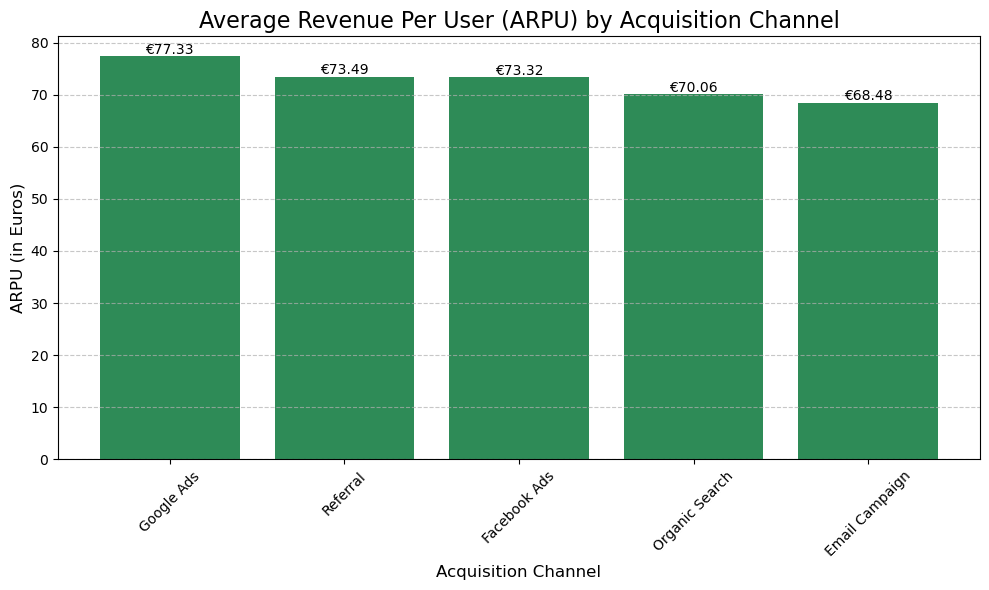

In [30]:


# Visualizing ARPU by acquisition channel
plt.figure(figsize=(10, 6))
bars = plt.bar(channel_data_sorted['acquisition_channel'], channel_data_sorted['ARPU'], color='seagreen')

# Adding labels on each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'€{height:.2f}', ha='center', fontsize=10)

# Customizing the chart
plt.title('Average Revenue Per User (ARPU) by Acquisition Channel', fontsize=16)
plt.xlabel('Acquisition Channel', fontsize=12)
plt.ylabel('ARPU (in Euros)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [31]:
# Filtering for users with more than one transaction
multi_transactions = data.groupby('user_id').filter(lambda x: len(x) > 1)

In [32]:
# Sorting data and calculate the time difference between transactions
multi_transactions = multi_transactions.sort_values(['user_id', 'transaction_date'])
multi_transactions['time_to_next'] = multi_transactions.groupby('user_id')['transaction_date'].diff()

In [33]:
# Sorting data and calculate the time difference between transactions
multi_transactions = multi_transactions.sort_values(['user_id', 'transaction_date'])
multi_transactions['time_to_next'] = multi_transactions.groupby('user_id')['transaction_date'].diff()

In [34]:
# Filtering for the time to second transaction (nth(1) = second transaction)
time_to_second = multi_transactions.groupby('user_id').nth(1)['time_to_next']

In [35]:
# Converting timedelta to days for easier analysis
time_to_second_days = time_to_second.dt.days

In [36]:
# Summary for statistics for time between first and second transactions
time_summary = time_to_second_days.describe()

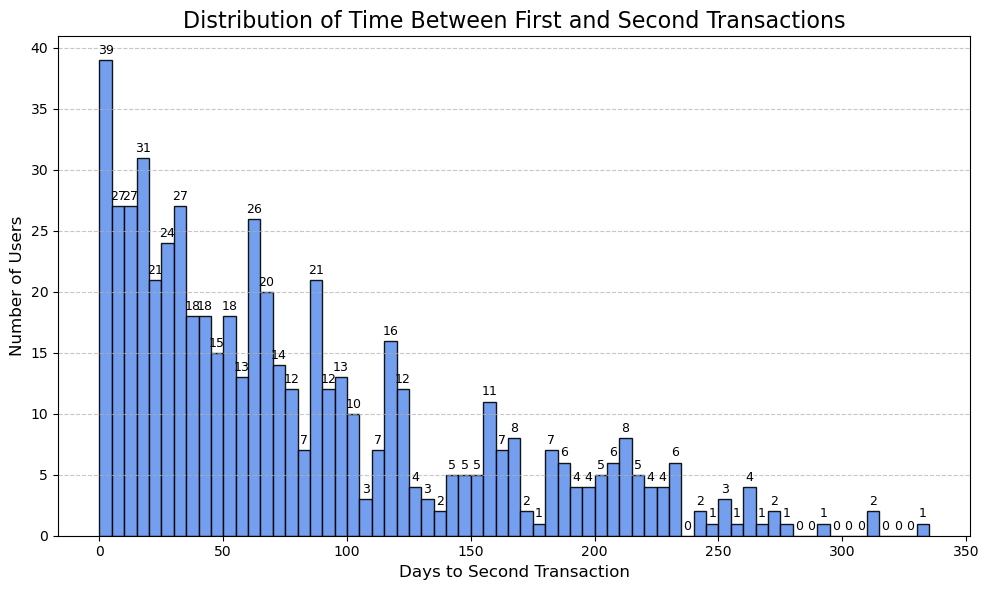

count    582.000000
mean      81.482818
std       71.109807
min        0.000000
25%       25.000000
50%       62.000000
75%      118.750000
max      331.000000
Name: time_to_next, dtype: float64

In [42]:
# Visualizing the distribution of time to second transaction
plt.figure(figsize=(10, 6))
bins = range(0, int(time_to_second_days.max()) + 5, 5)  # 5-day intervals
plt.hist(time_to_second_days, bins=bins, color='cornflowerblue', alpha=0.9, edgecolor='black')

# Adding grid and labels
plt.title('Distribution of Time Between First and Second Transactions', fontsize=16)
plt.xlabel('Days to Second Transaction', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding bin counts as labels
for i in range(len(bins) - 1):
    count = ((time_to_second_days >= bins[i]) & (time_to_second_days < bins[i + 1])).sum()
    plt.text(bins[i] + 2.5, count + 0.5, str(count), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# summary statistics
time_summary

In [43]:
# Group by acquisition_channel and calculate mean time to second transaction
channel_time = multi_transactions.groupby('acquisition_channel')['time_to_next'].mean().dt.days
print(channel_time)

acquisition_channel
Email Campaign    58
Facebook Ads      58
Google Ads        58
Organic Search    58
Referral          58
Name: time_to_next, dtype: int64


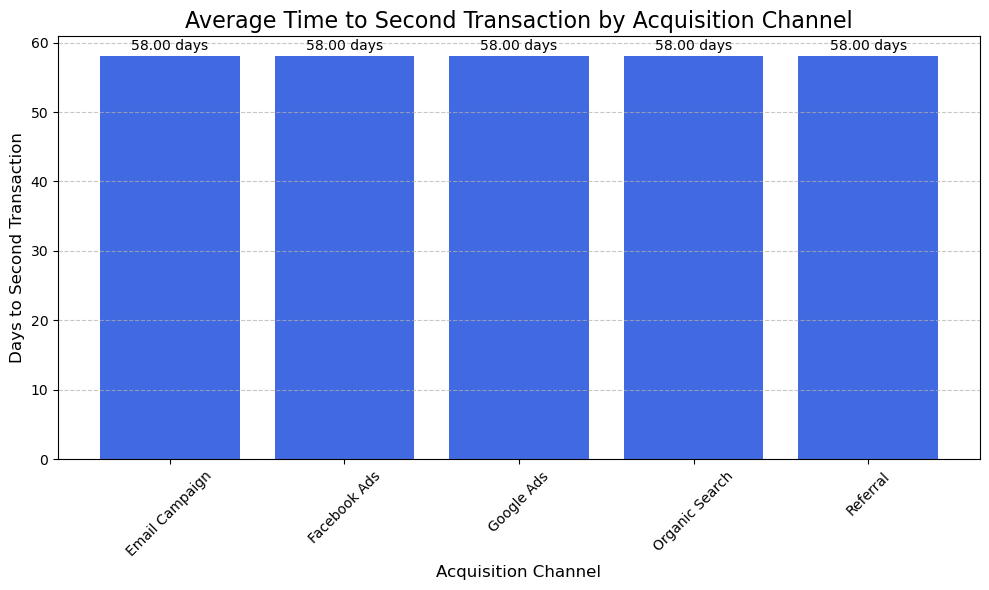

In [44]:
# Visualizing time to second transaction by channel
plt.figure(figsize=(10, 6))
bars = plt.bar(channel_time.index, channel_time, color='royalblue')

# Adding labels to bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.2f} days', ha='center', fontsize=10)

# Customizing the chart
plt.title('Average Time to Second Transaction by Acquisition Channel', fontsize=16)
plt.xlabel('Acquisition Channel', fontsize=12)
plt.ylabel('Days to Second Transaction', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [48]:
# Defining spending segments (e.g., Low, Medium, High)
spending_bins = [0, 25, 75, float('inf')]  # Define thresholds for spending
spending_labels = ['Low', 'Medium', 'High']

In [49]:
# Adding spending_segment to both data and multi_transactions
data['spending_segment'] = pd.cut(data['revenue'], bins=spending_bins, labels=spending_labels)
multi_transactions = pd.merge(multi_transactions, data[['user_id', 'spending_segment']], on='user_id', how='left')

In [50]:
# Analyzing time to second transaction by spending segment
spending_time = multi_transactions.groupby('spending_segment')['time_to_next'].mean().dt.days
print(spending_time)

spending_segment
Low       53
Medium    52
High      51
Name: time_to_next, dtype: int64


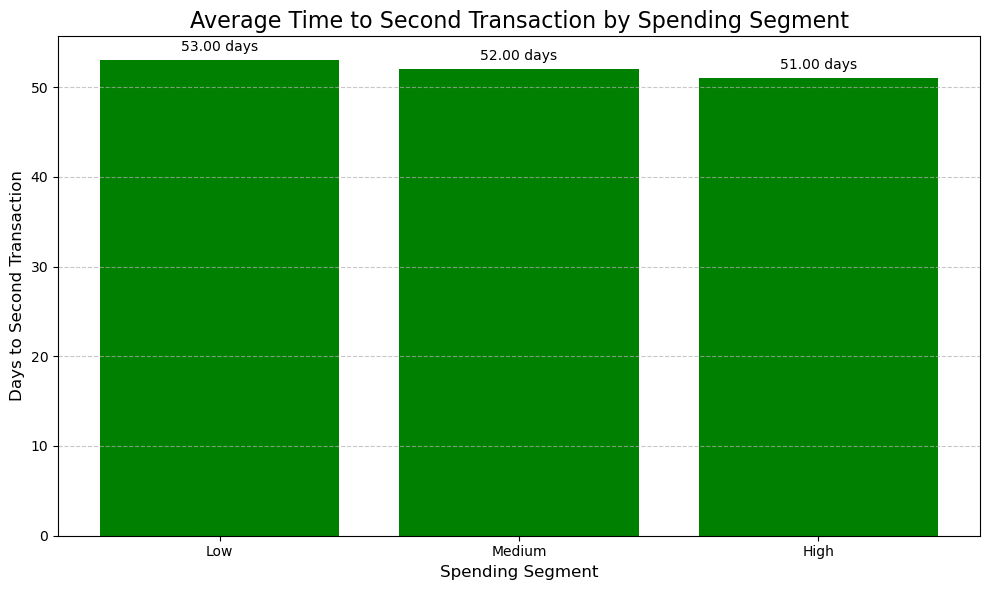

In [51]:
# Visualizing time to second transaction by spending segment
plt.figure(figsize=(10, 6))
bars = plt.bar(spending_time.index, spending_time, color='green')

# Adding labels to bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f} days', ha='center', fontsize=10)

# Customizing the chart
plt.title('Average Time to Second Transaction by Spending Segment', fontsize=16)
plt.xlabel('Spending Segment', fontsize=12)
plt.ylabel('Days to Second Transaction', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [52]:
# Analyzing time to second transaction by platform
platform_time = multi_transactions.groupby('platform')['time_to_next'].mean().dt.days
print(platform_time)

platform
app    53
web    51
Name: time_to_next, dtype: int64


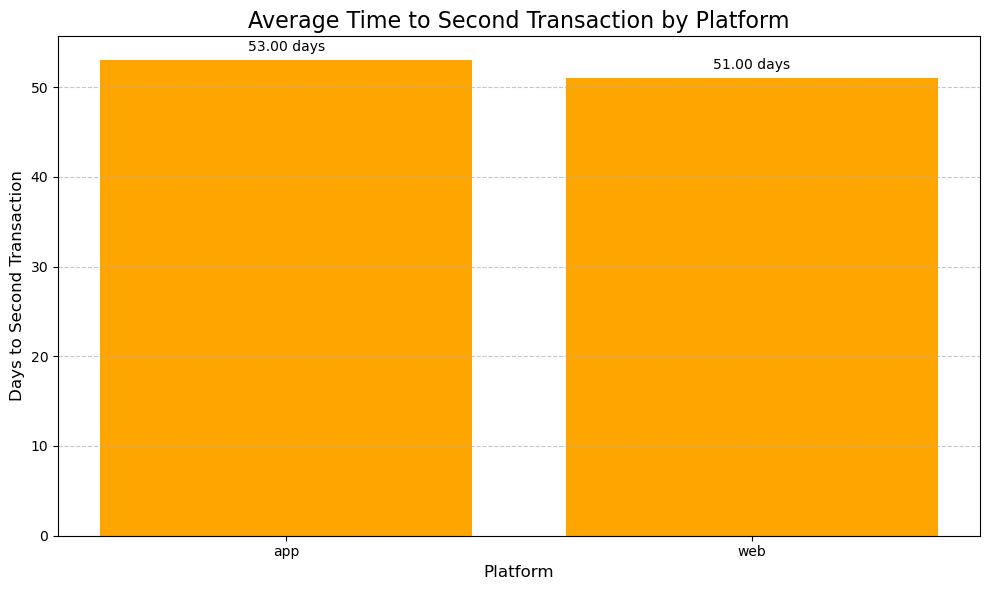

In [53]:
# Visualizing time to second transaction by platform
plt.figure(figsize=(10, 6))
bars = plt.bar(platform_time.index, platform_time, color='orange')

# Adding labels to bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.2f} days', ha='center', fontsize=10)

# Customizing the chart
plt.title('Average Time to Second Transaction by Platform', fontsize=16)
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Days to Second Transaction', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [55]:
#  confirming transaction_date is in datetime format
data['transaction_date'] = pd.to_datetime(data['transaction_date'])

# 1: Filtering for users with more than one transaction
multi_transactions = data.groupby('user_id').filter(lambda x: len(x) > 1)

# 2: Sorting data by user_id and transaction_date, and calculate the time difference between transactions
multi_transactions = multi_transactions.sort_values(['user_id', 'transaction_date'])
multi_transactions['time_to_next'] = multi_transactions.groupby('user_id')['transaction_date'].diff()

# 3: Extracting the time to the second transaction
time_to_second = multi_transactions.groupby('user_id').nth(1)['time_to_next']

# 4: Converting time differences to days for analysis
time_to_second_days = time_to_second.dt.days

# Quick analysis: Getting the range of days to return (min, max) and most frequent range (mode without statistics)
min_days = time_to_second_days.min()
max_days = time_to_second_days.max()
frequent_return_range = time_to_second_days.mode().iloc[0]

# Preparing a simple analysis summary
analysis_summary = {
    "Minimum Days to Second Transaction": min_days,
    "Maximum Days to Second Transaction": max_days,
    "Most Frequent Return Range (Days)": frequent_return_range
}

analysis_summary

{'Minimum Days to Second Transaction': 0,
 'Maximum Days to Second Transaction': 331,
 'Most Frequent Return Range (Days)': 18}

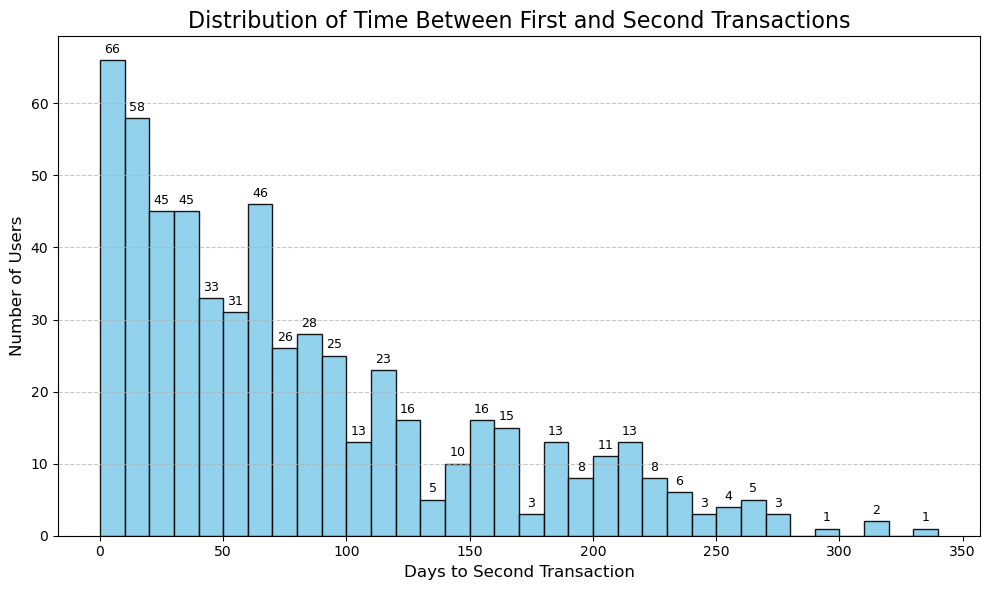

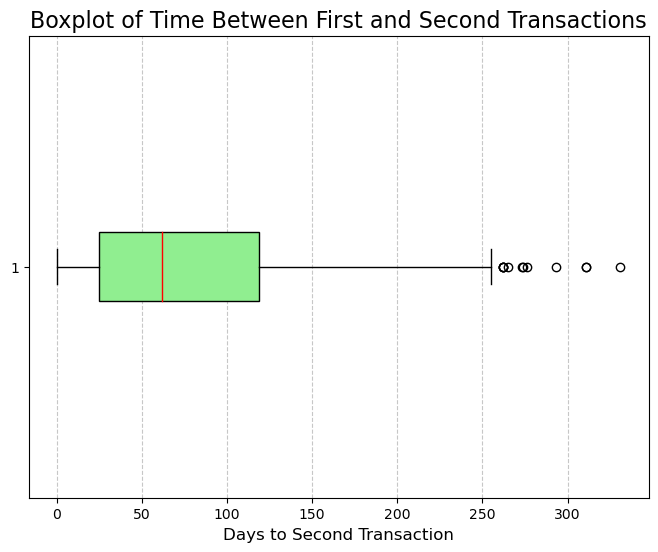

In [56]:
# Visualization 1: Distribution of Time to Second Transaction
plt.figure(figsize=(10, 6))
bins = range(0, int(time_to_second_days.max()) + 10, 10)  # 10-day intervals
plt.hist(time_to_second_days, bins=bins, color='skyblue', alpha=0.9, edgecolor='black')

# Adding labels and grid
plt.title('Distribution of Time Between First and Second Transactions', fontsize=16)
plt.xlabel('Days to Second Transaction', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding bin counts as labels
for i in range(len(bins) - 1):
    count = ((time_to_second_days >= bins[i]) & (time_to_second_days < bins[i + 1])).sum()
    if count > 0:  # Only label bins with counts
        plt.text(bins[i] + 5, count + 1, str(count), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Visualization 2: Boxplot of Time to Second Transaction
plt.figure(figsize=(8, 6))
plt.boxplot(time_to_second_days, vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen', color='black'), medianprops=dict(color='red'))
plt.title('Boxplot of Time Between First and Second Transactions', fontsize=16)
plt.xlabel('Days to Second Transaction', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()